# Federated Learning Results

Import required libraries

In [1]:
import os
import sys

import numpy as np

sys.path.append("/home/mn628/FEDERATED_LEARNING/mn628/")

In [36]:
from src.plot_notebooks import *
from src.seg_fedavg.client import UNetClient
from src.seg_fedavg.prepare_data import data_loading

## Loading and evaluating models on the test set

In [37]:
# Path to the results folder
folder_path = "/home/mn628/FEDERATED_LEARNING/mn628/results/seg_fedavg/normal/"

In [38]:
# Set paths to models
global_model_path = folder_path + "global_model_initial.h5"
client_0_model_path = folder_path + "client_model_0_initial.h5"
client_1_model_path = folder_path + "client_model_1_initial.h5"

In [39]:
# Load the testing data
_, _, _, _, test_images, test_masks = data_loading()

In [40]:
global_model = UNetClient(None, None, test_images, test_masks)
global_model.model.load_weights(global_model_path)

client_0_model = UNetClient(None, None, test_images, test_masks)
client_0_model.model.load_weights(client_0_model_path)

client_1_model = UNetClient(None, None, test_images, test_masks)
client_1_model.model.load_weights(client_1_model_path)

2025-07-03 20:41:26.255174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [34]:
metrics_global = global_model.evaluate()

222/222 [==============================] - 46s 208ms/step
Loss: 0.6825498335550696, Dice: 0.3174501664449304, IoU: 0.1886720738453185


In [41]:
metrics_client_0 = client_0_model.evaluate()

222/222 [==============================] - 39s 172ms/step
Loss: 0.6925016781394369, Dice: 0.3074983218605631, IoU: 0.18168272790050952


In [42]:
metrics_client_1 = client_1_model.evaluate()

222/222 [==============================] - 38s 171ms/step
Loss: 0.6967579194473683, Dice: 0.30324208055263163, IoU: 0.17871852966002197


## Plotting some results/samples

222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step


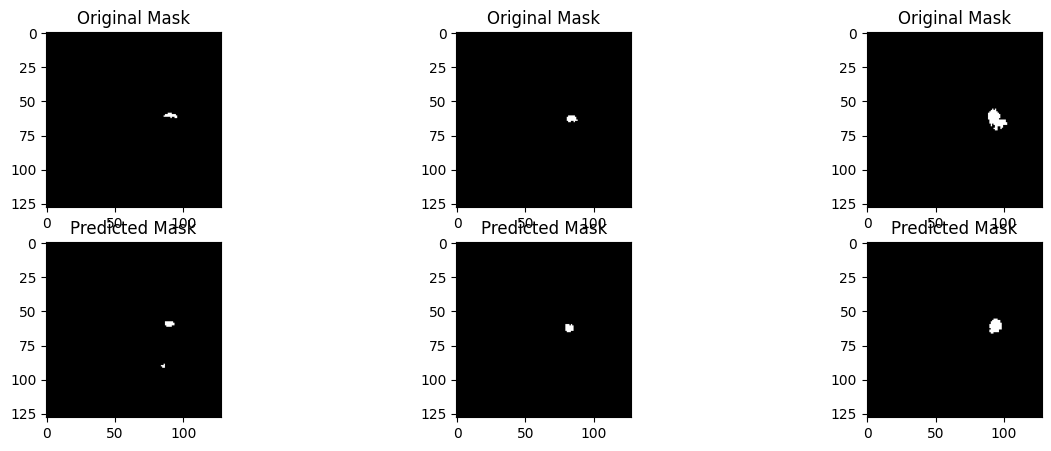

In [7]:
global_model.save_samples(global_model.x_val, global_model.y_val)

222/222 ━━━━━━━━━━━━━━━━━━━━ 76s 342ms/step


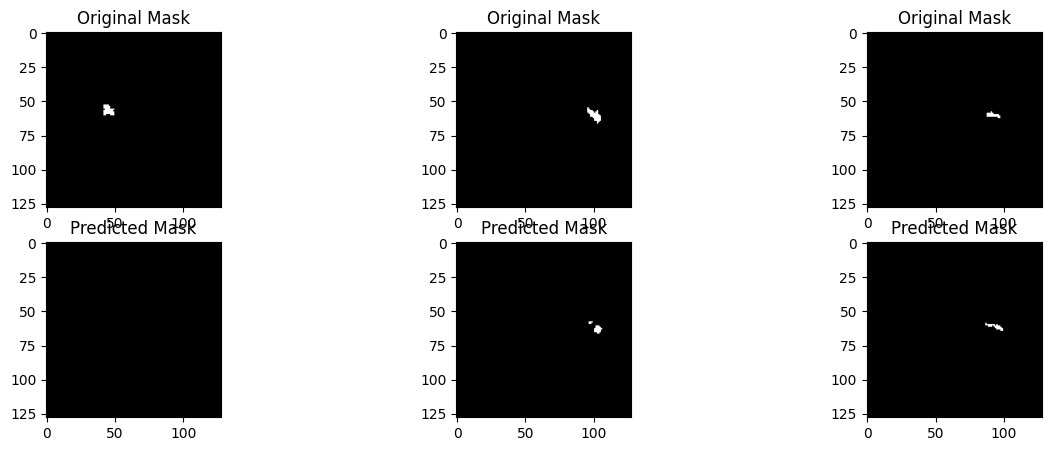

In [14]:
global_model.save_samples(global_model.x_val, global_model.y_val)

As the examples demonstrate, the models are generally successful in identifying lesion regions; however, most segmentation inaccuracies are concentrated around its boundaries. This is particularly relevant because evaluation metrics such as Dice and IoU are highly sensitive to even small deviations. Minor over- or under-segmentation in boundary areas can lead to noticeable performance drops. 

## Getting training/validation/testing data for plotting

#### Getting training/validation log

In [6]:
def files(folder_path):
    """List all files in the given folder."""
    txt_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt") and "timing" not in filename:
            txt_files.append(os.path.join(folder_path, filename))
    txt_files.sort()
    return txt_files

In [7]:
txt_files = files(folder_path)

In [8]:
def return_metrics(type_met="Training", txt_files=txt_files):
    all_training_loss, all_training_dice, all_training_iou = [], [], []
    for txt_file in txt_files:
        text_data = ""
        with open(txt_file, "r") as file:
            text_data = file.read()

        # separate the text data into lines
        lines = text_data.split("\n")
        # save only lines that have training in it
        training_lines = [line for line in lines if type_met in line]
        all_data = [training_lines[i].split(" ") for i in range(len(training_lines))]
        all_data = [
            [all_data[i][-5][:-1], all_data[i][-3][:-1], all_data[i][-1]]
            for i in range(len(all_data))
        ]
        all_data = np.array(all_data)
        # Convert the last column to float
        all_data = all_data.astype(float)
        # Sort the data by the last column (accuracy)
        training_data = all_data.T
        all_training_loss.append(training_data[0])
        all_training_dice.append(training_data[1])
        all_training_iou.append(training_data[2])
    return all_training_loss, all_training_dice, all_training_iou

##### Training curves

In [9]:
all_training_loss, all_training_dice, all_training_iou = return_metrics("Training")

##### Validation curves

In [7]:
all_validation_loss, all_validation_dice, all_validation_iou = return_metrics(
    "Validation"
)

#### Getting global models after each round

In [10]:
files = []

for filename in os.listdir(folder_path):
    if "global" in filename and "round" in filename:
        files.append(filename)

In [11]:
files.sort(key=lambda x: int(x.split("_")[3].split(".")[0]))
files

['global_model_round_1.h5',
 'global_model_round_2.h5',
 'global_model_round_3.h5',
 'global_model_round_4.h5',
 'global_model_round_5.h5',
 'global_model_round_6.h5',
 'global_model_round_7.h5',
 'global_model_round_8.h5',
 'global_model_round_9.h5',
 'global_model_round_10.h5']

#### Evaluating global models after each round on the test set

In [ ]:
losses, dices, ious = [], [], []
for file in files:
    global_model = UNetClient(None, None, test_images, test_masks)
    global_model.load_model(folder_path + file)

    metrics = global_model.evaluate()

    losses.append(metrics[0])
    dices.append(metrics[2]["dice"])
    ious.append(metrics[2]["iou"])

2025-06-02 22:52:22.375091: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 349ms/step
Loss: 0.49315502626845154, Dice: 0.5068449737315485, IoU: 0.33944564684499395


#### Saved evaluations

##### Statistical heterogeneity - 2 clients

In [16]:
all_losses = [
    0.4918422465132526,
    0.5053644437533729,
    0.5309216898889799,
    0.5275375218190329,
    0.576888062258333,
    0.6129822350759203,
    0.5945943296341321,
    0.6269997093186327,
    0.6266085027056808,
    0.6397196138147819,
]
all_dices = [
    0.5081577534867474,
    0.4946355562466272,
    0.46907831011102,
    0.4724624781809671,
    0.42311193774166705,
    0.3870177649240797,
    0.405405670365868,
    0.3730002906813673,
    0.3733914972943192,
    0.3602803861832081,
]
all_ious = [
    0.3406243218238512,
    0.3285819313051773,
    0.3064025503127053,
    0.3092968070717805,
    0.26832084525753164,
    0.23993926064899496,
    0.25423749654176014,
    0.22925651955867604,
    0.22955216124422337,
    0.21644105013311226,
]

In [17]:
all_losses_prox = [
    0.7374497308667946,
    0.4689179218494973,
    0.4674540615293218,
    0.47737440596346237,
    0.4986523258109651,
    0.47094075994557993,
    0.5029848149285857,
    0.5523412482629448,
    0.46826156896487225,
    0.5197660565363371,
]
all_dices_prox = [
    0.26255026913320545,
    0.5310820781505027,
    0.5325459384706782,
    0.5226255940365376,
    0.5013476741890349,
    0.5290592400544201,
    0.4970151850714143,
    0.44765875173705516,
    0.5317384310351277,
    0.48023394346366294,
]
all_ious_prox = [
    0.15111244053214826,
    0.3615464623658642,
    0.36290467445071517,
    0.35375297685335894,
    0.3345323431955713,
    0.35967406333481,
    0.330685433501888,
    0.2883765101507037,
    0.3621551106932565,
    0.3159920182440137,
]

In [18]:
max(all_dices), max(all_dices_prox), all_dices[-1], all_dices_prox[-1]

(0.5081577534867474,
 0.5325459384706782,
 0.3602803861832081,
 0.48023394346366294)

##### System heterogeneity - 2 clients

In [94]:
all_losses = [
    0.9441399168946119,
    0.6826713137071263,
    0.6665240897892144,
    0.7638669224650227,
    0.7244030537657697,
    0.8305009727465805,
    0.879342052893787,
    0.8885188322980514,
    0.8540956429898796,
    0.8086455368777269,
]
all_dices = [
    0.055860083105388154,
    0.31732868629287375,
    0.33347591021078565,
    0.2361330775349773,
    0.2755969462342303,
    0.16949902725341948,
    0.12065794710621303,
    0.11148116770194857,
    0.14590435701012044,
    0.19135446312227314,
]
all_ious = [
    0.028732542663191574,
    0.18858625787930067,
    0.20010266413428468,
    0.13387238828934941,
    0.15982165285104244,
    0.09259707029769788,
    0.06420222807254564,
    0.059031006625595725,
    0.07869300462560705,
    0.1057998702457803,
]

In [95]:
all_losses_prox = [
    0.7223473049041653,
    0.5108680201664,
    0.5312803590369197,
    0.5101451394728184,
    0.5266132572431959,
    0.5357571204387148,
    0.5099199469047007,
    0.531153019813798,
    0.49374014195583593,
    0.48140478603787706,
]
all_dices_prox = [
    0.27765269509583473,
    0.48913197983359996,
    0.4687196409630802,
    0.48985486052718163,
    0.4733867427568042,
    0.46424287956128524,
    0.49008005309529934,
    0.46884698018620197,
    0.5062598580441641,
    0.5185952139621229,
]
all_ious_prox = [
    0.16120598575284667,
    0.323742360884526,
    0.30609655390465257,
    0.324376013750696,
    0.31008950073685343,
    0.30228925745020574,
    0.3245735339147957,
    0.30620517617711257,
    0.3389209701369411,
    0.35006989234127084,
]

In [96]:
max(all_dices), max(all_dices_prox), all_dices[-1], all_dices_prox[-1]

(0.33347591021078565,
 0.5185952139621229,
 0.19135446312227314,
 0.5185952139621229)

##### Statistical heterogeneity - 6 clients

In [102]:
all_losses = [
    0.5955630606206138,
    0.5238971387178559,
    0.5621187490126331,
    0.6052737999908944,
    0.6565788990385023,
    0.6825351827477979,
    0.6910284438482956,
    0.650640495230295,
    0.6694254001209203,
    0.7215551846467692,
]
all_dices = [
    0.4044369393793862,
    0.47610286128214413,
    0.4378812509873668,
    0.3947262000091057,
    0.3434211009614977,
    0.3174648172522021,
    0.3089715561517044,
    0.349359504769705,
    0.3305745998790796,
    0.2784448153532308,
]
all_ious = [
    0.25347599813577754,
    0.312424539154078,
    0.2803123970339246,
    0.2458933796909566,
    0.2073074220375639,
    0.18868242430077503,
    0.18271221709823743,
    0.2116508747841927,
    0.1980169942634965,
    0.161740278694791,
]

In [103]:
all_losses_prox = [
    0.7904038891393513,
    0.5023571723128164,
    0.4605467163967707,
    0.48947492492338596,
    0.48987074583939516,
    0.48698135684465194,
    0.49598773075435876,
    0.4866258861314485,
    0.4801688417934442,
    0.47923610854868004,
]
all_dices_prox = [
    0.20959611086064864,
    0.4976428276871836,
    0.5394532836032293,
    0.510525075076614,
    0.5101292541606048,
    0.5130186431553481,
    0.5040122692456412,
    0.5133741138685515,
    0.5198311582065558,
    0.52076389145132,
]
all_ious_prox = [
    0.11706638492692376,
    0.3312413564885394,
    0.3693502423079509,
    0.34275506524748905,
    0.3423983292411029,
    0.3450067755011835,
    0.33690936020677836,
    0.34532838332613197,
    0.3511972036762395,
    0.35204920191020483,
]

In [16]:
max(all_dices), max(all_dices_prox), all_dices[-1], all_dices_prox[-1]

(0.47610286128214413, 0.5394532836032293, 0.2784448153532308, 0.52076389145132)

##### Statistical heterogeneity - 10 clients

In [12]:
all_losses_prox = [
    0.9948202916562787,
    0.5531843620833923,
    0.5245519977952002,
    0.482727558979796,
    0.4770558892395399,
    0.4823017983057285,
    0.48260241943682014,
    0.4946754479358608,
    0.49315502626845154,
    0.47225667396927895,
]
all_dices_prox = [
    0.005179708343721278,
    0.44681563791660767,
    0.4754480022047997,
    0.517272441020204,
    0.5229441107604601,
    0.5176982016942715,
    0.5173975805631799,
    0.5053245520641392,
    0.5068449737315485,
    0.527743326030721,
]
all_ious_prox = [
    0.0025965789326419073,
    0.28767714176394577,
    0.3118607977244399,
    0.34886546613871394,
    0.3540449041706182,
    0.34925289997354164,
    0.34897931757032874,
    0.33808312885716413,
    0.33944564684499395,
    0.35845877649031,
]

In [13]:
max(all_dices_prox), all_dices_prox[-1]

(0.527743326030721, 0.527743326030721)

## Learning curves and comparisons 

### Initial federated learning setup - 2 Clients

Federated Learning 

In [55]:
folder_path = "/home/mn628/FEDERATED_LEARNING/mn628/results/seg_fedavg/normal_2/"
text_files = files(folder_path)

all_validation_loss, all_validation_dice, all_validation_iou = return_metrics(
    "Validation", text_files
)

Centralised training 

In [56]:
unet_history_0 = {}
with open(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_segmentation/results_2_equal_clients/unet_history_0.txt",
    "r",
) as file:
    lines = file.readlines()
    for line in lines:
        nums = line.strip().split(": ")[1].split("[")[1].split("]")[0].split(", ")
        nums = [float(num) for num in nums if num]
        unet_history_0[line.strip().split(": ")[0]] = nums

unet_history_1 = {}
with open(
    "/home/mn628/FEDERATED_LEARNING/mn628/results/UNet_segmentation/results_2_equal_clients/unet_history_1.txt",
    "r",
) as file:
    lines = file.readlines()
    for line in lines:
        nums = line.strip().split(": ")[1].split("[")[1].split("]")[0].split(", ")
        nums = [float(num) for num in nums if num]
        unet_history_1[line.strip().split(": ")[0]] = nums

In [57]:
unet_history_1.keys()

dict_keys(['loss', 'dice_coef', 'iou', 'val_loss', 'val_dice_coef', 'val_iou'])

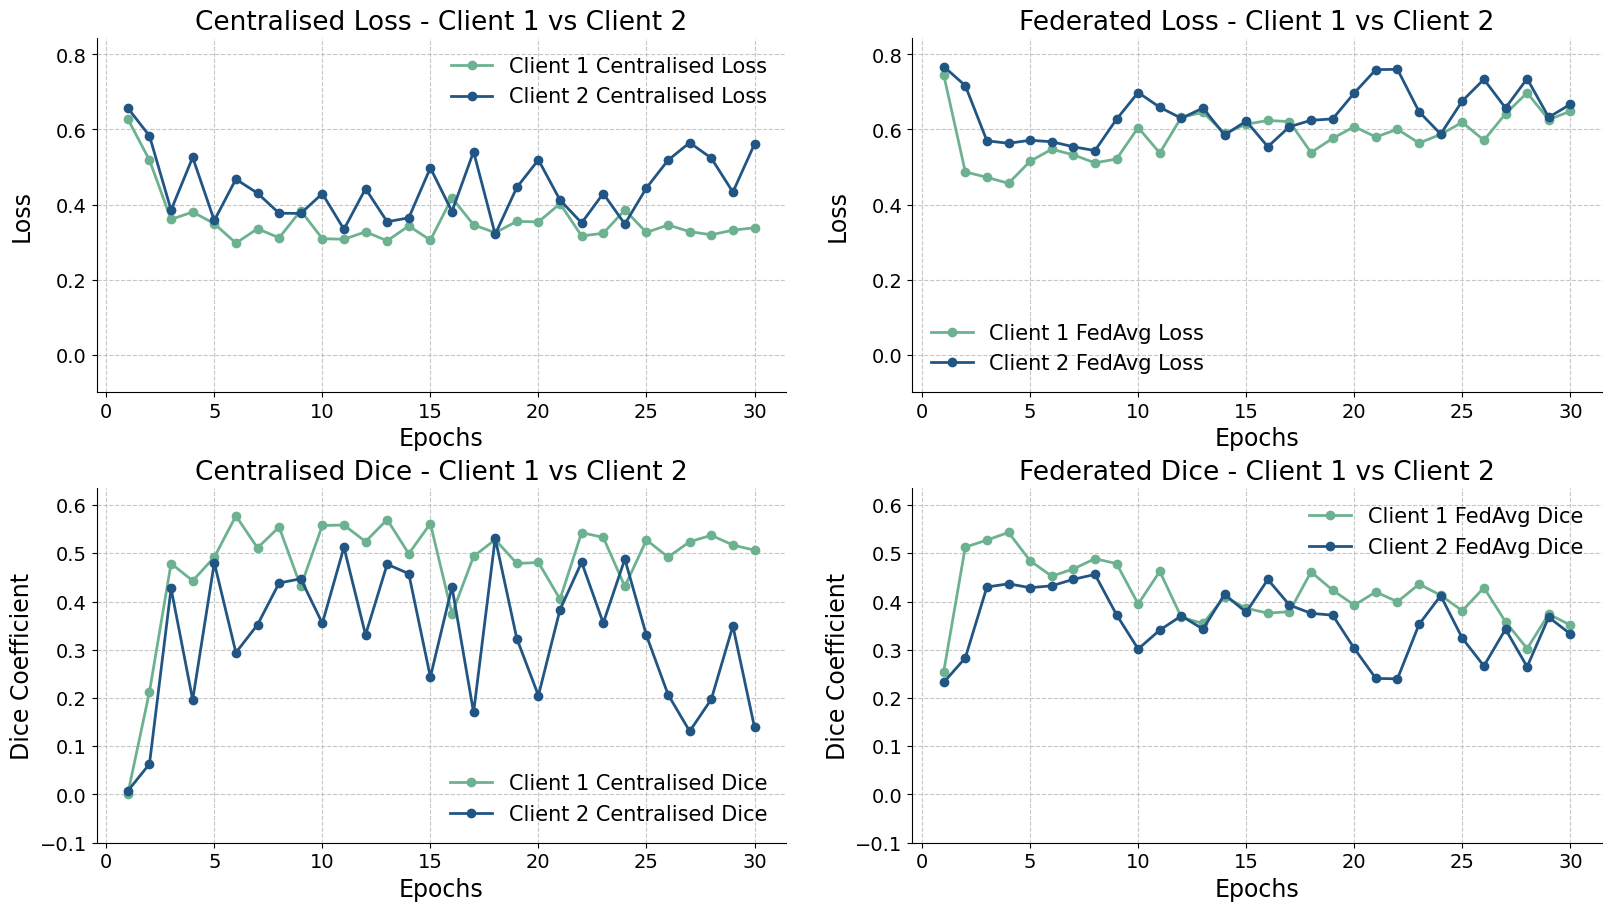

In [58]:
federated_initial_comparison(
    unet_history_0, unet_history_1, all_validation_loss, all_validation_dice
)

It can be observed that centralised training on the second half of the dataset resulted in a less stable validation loss and Dice curves. When evaluated, the two centralised models achieved final Dice scores of 0.454 and 0.259, respectively, indicating that the second half of the dataset is more challenging to learn from. This discrepancy may be partially attributed to differences in lesion composition across dataset splits.

When FedAvg was applied to this two-client setup, both clients showed slightly increasing validation loss over time. Final test Dice scores were 0.307 and 0.303 for Clients 1 and 2, respectively. While the federated setup slightly improved Client 2’s performance compared to its centralised baseline, it came at the cost of reduced accuracy for Client 1 due to naïve averaging. Nonetheless, this initial case demonstrates the trade-offs and potential benefits of federated learning in scenarios with imbalanced but moderately overlapping data distributions.

### Statistical Heterogeneity - 2 Clients Setup

Federated Learning - FedAvg

In [19]:
folder_path = (
    "/home/mn628/FEDERATED_LEARNING/mn628/results/seg_fedavg/statistical_het_2/"
)
text_files = files(folder_path)

all_validation_loss, all_validation_dice, all_validation_iou = return_metrics(
    "Validation", text_files
)

FedProx

In [20]:
folder_path_prox = (
    "/home/mn628/FEDERATED_LEARNING/mn628/results/seg_fedprox/statistical_het_2/"
)
text_files_prox = files(folder_path_prox)

all_validation_loss_prox, all_validation_dice_prox, all_validation_iou_prox = (
    return_metrics("Validation", text_files_prox)
)

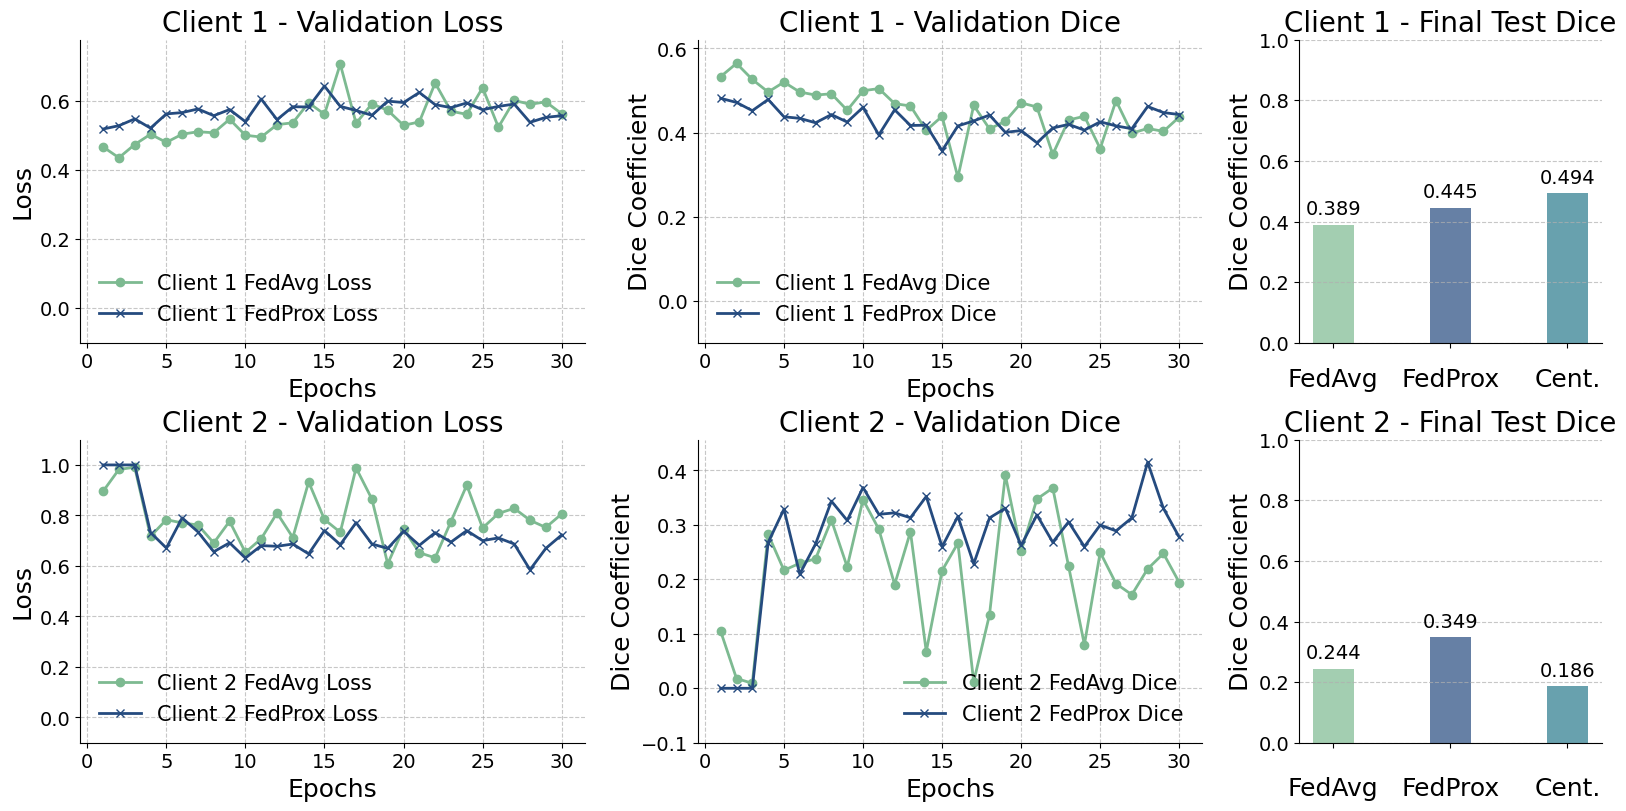

In [21]:
epochs = np.arange(1, 31)
epochs1 = np.arange(1, 31)
client1_final = [0.389, 0.445, 0.494]
client2_final = [0.244, 0.349, 0.186]
fed_2_comparison(
    all_validation_loss,
    all_validation_dice,
    all_validation_loss_prox,
    all_validation_dice_prox,
    client1_final,
    client2_final,
    epochs,
    epochs1,
)

- As illustrated in figure above, FedProx stabilises the training process for both clients, with a more pronounced effect observed for Client 2.   
- The evaluation of the final models on the test set suggested that: the Dice coefficient increased by 5.6% for Client 1 and by 10.5% for Client 2. When compared to the performance of the centralised models trained on their respective datasets, it is evident that Client 2, which was trained on only the last 30% of the data, achieved a relatively low Dice score of 0.186.

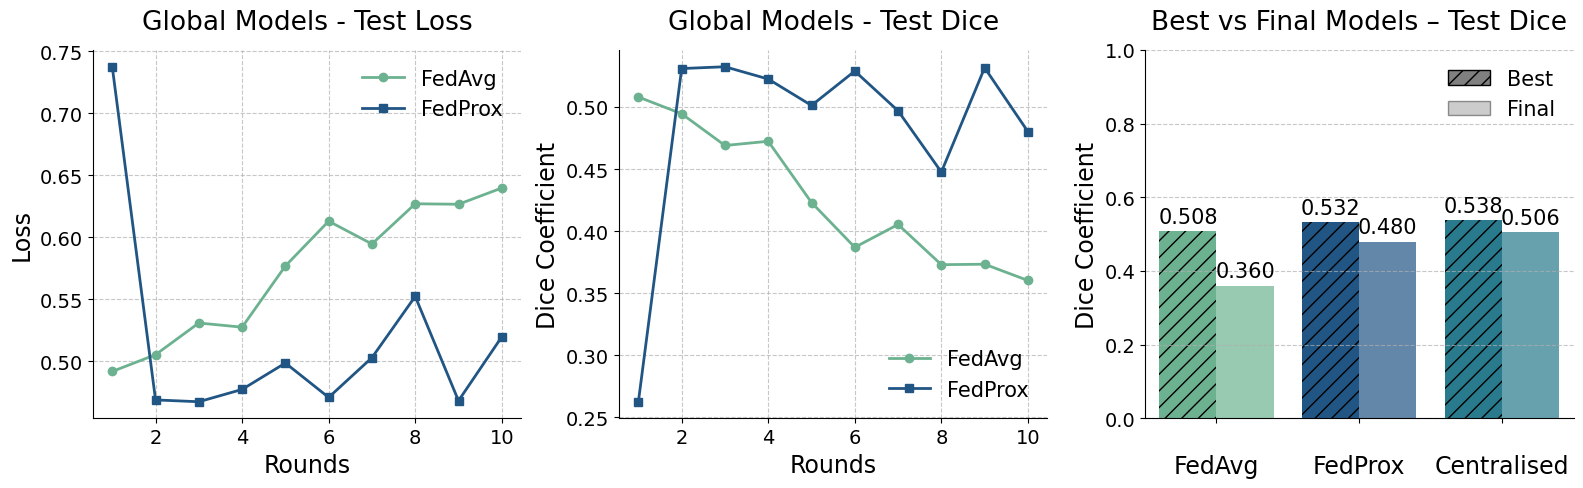

In [22]:
best_dices = [0.5082, 0.5325, 0.538]
final_dices = [0.3603, 0.4802, 0.5059]
fed_2_global(
    all_losses, all_dices, all_losses_prox, all_dices_prox, best_dices, final_dices
)

- In the case of FedAvg, the test loss increases and the Dice score steadily declines over time (left and middle plots), likely due to one client with less data producing updates that diverge significantly from the global model.          
- In contrast, FedProx demonstrates improved performance, with the Dice score gradually increasing across rounds. This indicates that the proximal term effectively constrains client updates and mitigates divergence from the global objective, particularly in the presence of non-IID and imbalanced data.     
- The final Dice score improves from 0.36 (FedAvg) to 0.48 (FedProx), approaching the 0.506 achieved by the centralised model. In terms of best-round performance, FedAvg reaches 0.508 , while FedProx attains 0.532 , nearly matching the highest score observed in the cenntralised setting (0.538 ). 

### System heterogeneity - 2 Clients Setup

Federated Learning - FedAvg

In [97]:
folder_path = "/home/mn628/FEDERATED_LEARNING/mn628/results/seg_fedavg/system_het_2/"
text_files = files(folder_path)

all_validation_loss, all_validation_dice, all_validation_iou = return_metrics(
    "Validation", text_files
)

FedProx

In [98]:
folder_path_prox = (
    "/home/mn628/FEDERATED_LEARNING/mn628/results/seg_fedprox/system_het_2/"
)
text_files_prox = files(folder_path_prox)

all_validation_loss_prox, all_validation_dice_prox, all_validation_iou_prox = (
    return_metrics("Validation", text_files_prox)
)

Centralised results

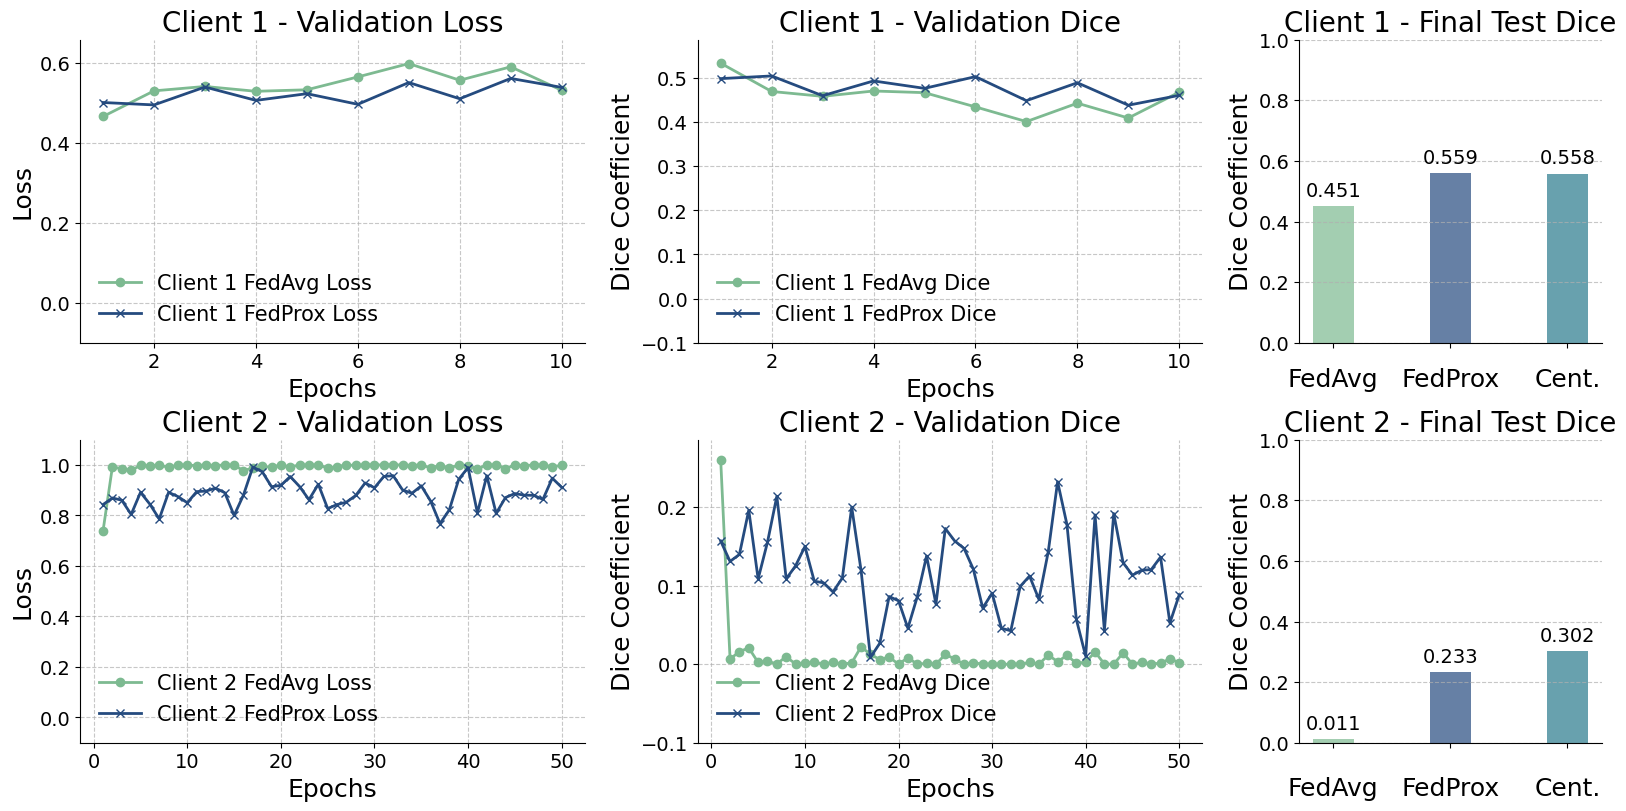

In [99]:
epochs = np.arange(1, 11)
epochs1 = np.arange(1, 51)
client1_final = [0.451, 0.559, 0.558]
client2_final = [0.011, 0.233, 0.302]
fed_2_comparison(
    all_validation_loss,
    all_validation_dice,
    all_validation_loss_prox,
    all_validation_dice_prox,
    client1_final,
    client2_final,
    epochs,
    epochs1,
)

- Due to this larger number of local epochs, Client 2 exhibited clear signs of overfitting, with validation performance deteriorating over time. 
- The introduction of FedProx improved the performance of both clients: Client 1’s Dice score reached 0.559, nearly identical to the 0.558 achieved after 10 epochs of centralised training, while Client 2’s score increased substantially from 0.011 to 0.233. 
- The issue of overfitting with a large number of local epochs was also observed when training a centralised model for 50 epochs on Client 2’s dataset, which resulted in a Dice score of 0.302.

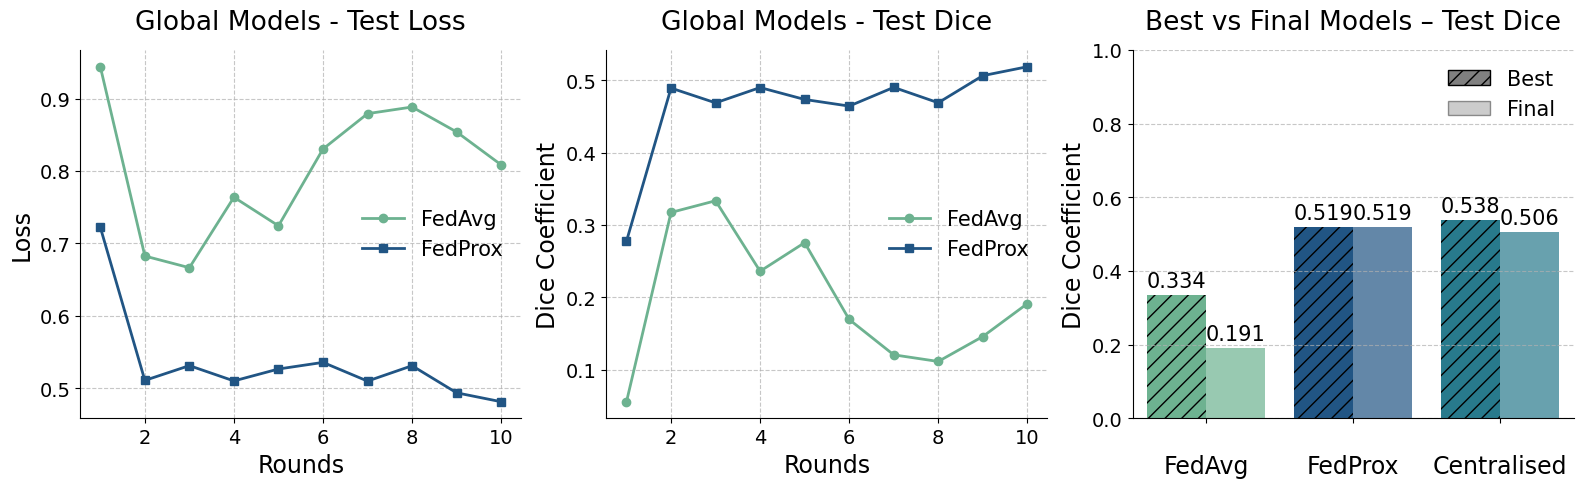

In [101]:
best_dices = [0.334, 0.519, 0.538]
final_dices = [0.191, 0.519, 0.506]
fed_2_global(
    all_losses, all_dices, all_losses_prox, all_dices_prox, best_dices, final_dices
)

- Similar improvements were observed, where FedProx effectively reduced and stabilised the loss after each aggregation round. 
- The overall Dice score of the final global model increased significantly from 0.191 to 0.519, making its performance comparable to that of centralised training.

### Statistical Heterogeneity - 6 Clients Setup

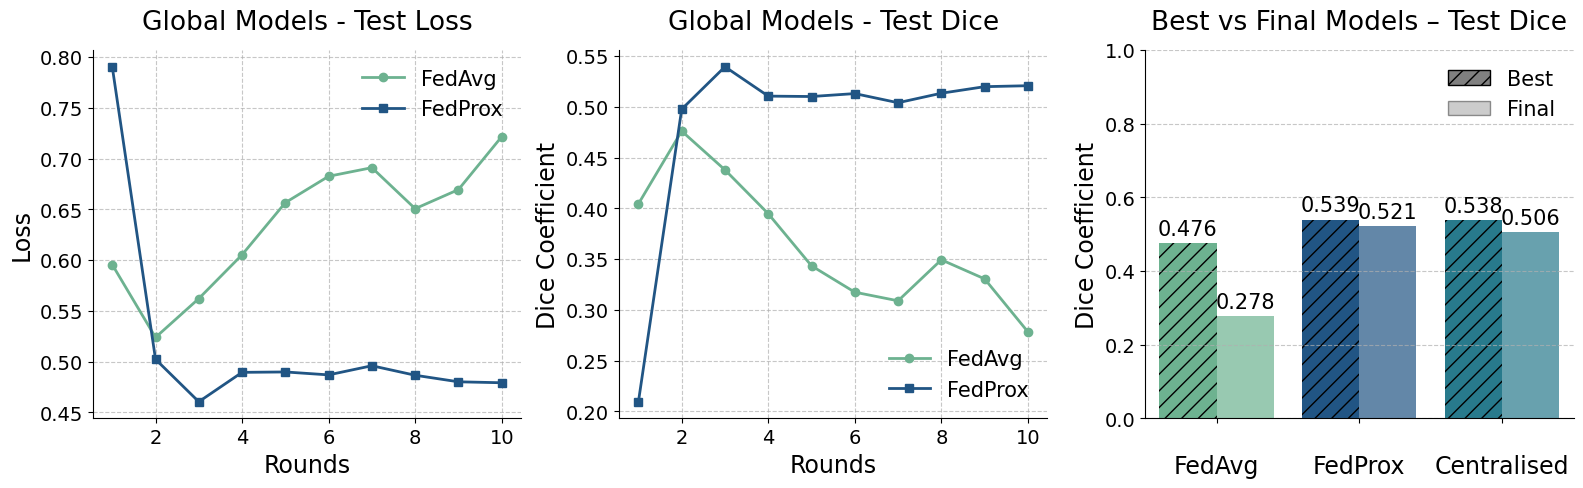

In [104]:
epochs = np.arange(1, 11)
best_dices = [0.476, 0.539, 0.538]
final_dices = [0.278, 0.521, 0.506]
fed_2_global(
    all_losses, all_dices, all_losses_prox, all_dices_prox, best_dices, final_dices
)

- It is noticeable that under the FedAvg approach, the global model’s performance deteriorates significantly over training epochs. Given that the data distribution consists of 50% for the first client and 10% for each of the other five clients, the clients with smaller datasets lack sufficient data to learn meaningful patterns. As a result, their models converge in widely different directions, causing the naive averaging in FedAvg to degrade the global model’s performance, which is initially dominated by the client with the largest data share. Introducing FedProx stabilises this process, leading to consistent small increases in overall test metrics after nearly every iteration. 
- Regarding the final and best model metrics, FedAvg yields poor final results with a Dice score of 0.278 , and a best early training score of 0.476 . In contrast, FedProx achieves a final Dice score of 0.521, surpassing even the centralised model’s 0.506 . The best FedProx performance exceeds the centralised model by 0.1% , demonstrating that under this setting the global model trained with FedProx performs satisfactorily.


### Summary and Comparison of Heterogeneity Experiments

| Problem     | # Clients | Method   | Dice Best | Dice Final | IoU Best | IoU Final | Time (h:m:s) |
|-------------|-----------|----------|------------|--------------|-----------|-------------|---------------|
| Statistical | 2         | FedAvg   | 0.508      | 0.360        | 0.340     | 0.220       | 06:12:53      |
|             |           | FedProx  | 0.532      | 0.480        | 0.362     | 0.316       | -             |
|             | 6         | FedAvg   | 0.476      | 0.278        | 0.312     | 0.161       | 05:57:11      |
|             |           | FedProx  | 0.539      | 0.521        | 0.369     | 0.352       | -             |
|             | 10        | FedAvg   | 0.322      | 0.121        | 0.192     | 0.064       | 03:49:44      |
|             |           | FedProx  | 0.528      | 0.528        | 0.359     | 0.359       | -             |
| System      | 2         | FedAvg   | 0.334      | 0.191        | 0.200     | 0.106       | 07:53:35      |
|             |           | FedProx  | 0.519      | 0.519        | 0.350     | 0.350       | -             |


Finally, the Table above summarises the results obtained across all heterogeneity scenarios studied. Both the best and final Dice and IoU scores are reported, demonstrating consistent improvements achieved by FedProx in comparison to FedAvg.